# Co-training

**Autori:** Peter Macinec, Lukas Janik, Vajk Pomichal, Frantisek Sefcik

### Zakladne nastavenia a import kniznic

In [35]:
import pandas as pd
import numpy as np


# plots
import matplotlib.pyplot as plt
import seaborn as sns

import json

import re

pd.options.mode.chained_assignment = None  # default='warn'

### Nacitanie datasetu

Nase data su dostupne v dvoch suboroch, *train.tsv* a *test.tsv*. Nacitame ich oba a vykoname na nich zakladnu analyzu. Zdroj: https://www.kaggle.com/c/stumbleupon

In [2]:
# trenovacie data
df = pd.read_csv('data/train.tsv', sep='\t')

In [3]:
# testovacie data
df_t = pd.read_csv('data/test.tsv', sep='\t')

## Deskriptivna analyza

Na zaciatok sa pozrime, kolko nase dva datasety obsahuju zaznamov. Najprv trenovacie data:

In [4]:
len(df)

7395

A testovacie data:

In [5]:
len(df_t)

3171

Podme na tieto data nahliadnut:

In [4]:
pd.options.display.max_columns = None

In [7]:
df.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


Vidime, ze data obsahuju rozne atributy s roznymi datovymi typmi. Niektore stlpce obsahuju cisla, ine ocividne hodnoty True/False, kategorie alebo text. Pozrime sa na datove typy vsetkych atributov:

In [8]:
df.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                            object
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

Taktiez bude pre nas zaujimavy pocet chybajucich hodnot v datach, aby sme vedeli urcit, ci pre nas jednotlive atributy su relevantne:

In [9]:
df.isnull().values.any()

False

Zda sa, ze v datach sa nenachadzaju ziadne chybajuce hodnoty. Niektore atributy vsak mozu obsahovat chybajuce hodnoty, ktore budu reprezentovane nejakou hodnotou. Na tento pripad si treba dat pozor. Ak takyto pripad nastane, mali by sme ho odhalit v explorativnej analyze, kde sa pozrieme na jednotlive atributy blizsie.

Pozrime sa este na vsetky atributy v skratke a ich agregovane veliciny. Najskor opisme numericke atributy:

In [10]:
df.describe()

,urlid,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
count,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.0,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,5305.704665,2.761823,0.468230,0.214080,0.092062,0.049262,2.255103,-0.103750,0.0,0.056423,0.021231,0.233778,0.275709,0.660311,30.077079,5716.598242,178.754564,4.960649,0.172864,0.101221,0.513320
std,3048.384114,8.619793,0.203133,0.146743,0.095978,0.072629,5.704313,0.306545,0.0,0.041446,0.144162,0.052487,1.919320,0.473636,20.393101,8875.432430,179.466198,3.233111,0.183286,0.079231,0.499856
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.045564,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2688.500000,1.602062,0.340370,0.105263,0.022222,0.000000,0.442616,0.000000,0.0,0.028502,0.000000,0.201061,0.025900,0.000000,14.000000,1579.000000,82.000000,3.000000,0.040984,0.068739,0.000000
50%,5304.000000,2.088235,0.481481,0.202454,0.068627,0.022222,0.483680,0.000000,0.0,0.045775,0.000000,0.230564,0.083051,1.000000,25.000000,3500.000000,139.000000,5.000000,0.113402,0.089312,1.000000
75%,7946.500000,2.627451,0.616604,0.300000,0.133333,0.065065,0.578227,0.000000,0.0,0.073459,0.000000,0.260770,0.236700,1.000000,43.000000,6377.000000,222.000000,7.000000,0.241299,0.112376,1.000000
max,10566.000000,363.000000,1.000000,1.000000,0.980392,0.980392,21.000000,0.250000,0.0,0.444444,1.000000,0.716883,113.333333,1.000000,100.000000,207952.000000,4997.000000,22.000000,1.000000,1.000000,1.000000


V pripade avglinksize je na prvy pohlad maximalna hodnota 363 velmi extremna, oproti priemeru 2, taktiez atribut 'compression_ratio' ma vysoky kladny extrem. Tieto (a dalsie) problemy v datach sa budeme snazit odhalit pocas analyzy.

Este sa pozrime na kategoricke a textove atributy:

In [11]:
df.describe(exclude=[np.number])

,url,boilerplate,alchemy_category,alchemy_category_score,is_news,news_front_page
count,7395,7395,7395,7395,7395,7395
unique,7395,7394,14,4806,2,3
top,http://mo2no.com/just-my-dad-enjoying-this-tro...,"{""title"":""Freebase Pancakes NOTCOT "",""body"":""n...",?,?,1,0
freq,1,2,2342,2342,4552,5853


Z opisu dat vidime, ze sa tu zrejme nachadzaju aj chybajuce hodnoty, ktore su oznacene otaznikom. Taktiez, ze sa v datach mozu nachadzat nejake duplikaty (boilerplate, top ma frekvenciu 2). Vidime taktiez, ze nie vsetky kategoricke atributy su naozaj kategoricke. Napriklad *alchemy_category_score* je zrejme numericky atribut, kde chybajuce hodnoty su nahradene znakom otaznika. Rovnaky problem, ale opacny mohol nastat pri numerickych atributoch, ze niektore numericke atributy predstavuju vlastne len kategorie. To bude treba este preskumat pocas analyzy a pripadne to opravit vo faze predspracovania dat.

## Analyza jednotlivych atributov

V tejto casti sa pozrieme na jednotlive atributy trocha hlbsie. Pokusime sa najst atributy, ktore by mohli napomoct klasifikacii.

Pre realizaciu explorativnej analyzy potrebujeme zadefinovat funkcie, ktore budeme pouzivat:

In [12]:
def grouped_barplot(df, attribute, groupby, title=None, size=(5, 4), rotation=0):
    """Draw barplot of attribute, grouped by another attribute."""
    plt.rcParams['figure.figsize'] = size
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data)
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.rcParams['figure.figsize'] = (5, 4)

def grouped_kdeplot(df, column, groupby, rotation=0):
    """Draw kdeplot of attribute, grouped by another attribute."""
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][column], shade=True, shade_lowest=False)
    plt.xticks(rotation=rotation)

def pie_plot(df, column, title=None, size=(5, 4)):
    """Draw pie plot with percentage of each value."""
    values = [len(df[df[column] == x]) for x in df[column].unique() if x != None]
    labels = [x for x in df[column].unique() if x != None]
    plt.rcParams['figure.figsize'] = size
    plt.pie(x = values, labels = labels, autopct='%1.2f%%')
    plt.title(title)
    plt.rcParams['figure.figsize'] = (5, 4)

### Label

Obsahuje informaciu, ktoru chceme predikovat, preto budeme skumat ostatne atributy v zavislosti od hodnot v tomto stlpci. 1 znamena, ze stranka je 'evergreen', teda aktualnost jej obsahu nie je len sezonalna alebo casovo obmedzena (napriklad vysledky volieb su aktualne iba kratky cas po volbach, ale recept moze byt zaujimavy aj po niekolkych rokoch). 0 znamena, ze stranka nie je 'evergreen'.

In [13]:
df.label.value_counts()

1    3796
0    3599
Name: label, dtype: int64

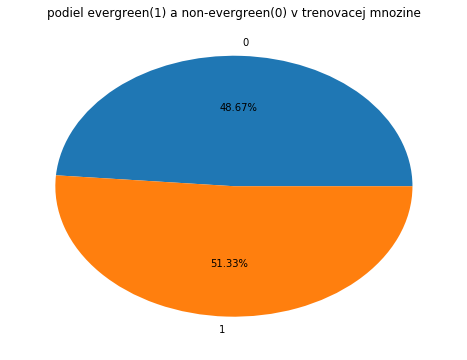

In [14]:
pie_plot(df,'label', title='podiel evergreen(1) a non-evergreen(0) v trenovacej mnozine', size=(8,6))

Rozdelenie hodnot je pomerne vyrovnane

### URL

obsahuje url webovej stranky

In [15]:
df.shape

(7395, 27)

In [16]:
df.url.nunique()

7395

Kazda riadok obsahuje unikatnu URL adresu, stranky (alebo aspon adresy stranok) sa nevyskytuju duplicitne.

### Boilerplate
Obsahuje text nachadzajuci sa na stranke, konretne obsah, nadpis a url

In [17]:
print('Pocet unikatnych hodnot pre boilerplate: ' + str(len(df['boilerplate'].unique())))

Pocet unikatnych hodnot pre boilerplate: 7394


Mame 7395 roznych url, ale zda sa, ze dve stranky maju rovnaky obsah. Kedze sa opakuje len 1 stranka, mozeme ju ziskat funkciou mode()

In [18]:
df.boilerplate.mode()[0]

'{"title":"Freebase Pancakes NOTCOT ","body":"notcot in food drink 13 03 Every now and then a series of images comes along and just blows your mind I couldn t stop laughing and then just kind of staring amazement at the micro scale cooking going on here my friend is calling them Freebase Pancakes How one even comes up with a concept such as this amazes me See full set of imagery below via Random Stuff Tags food technology ","url":"notcot archives 2007 04 freebase pancak php"}'

In [19]:
df[df.boilerplate == df.boilerplate.mode()[0]]

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
98,http://www.notcot.com/archives/2007/04/freebas...,2180,"{""title"":""Freebase Pancakes NOTCOT "",""body"":""n...",?,?,1.110132,0.867684,0.197201,0.077608,0.068702,0.678947,0.0,0,0.006795,0,0.147318,0.295775,?,0,51,?,2780,786,3,0.0,0.12,1
2688,http://www.notcot.com/archives/2007/04/freebas...,7840,"{""title"":""Freebase Pancakes NOTCOT "",""body"":""n...",arts_entertainment,0.37427,1.110783,0.872123,0.200767,0.079284,0.069054,0.678947,0.0,0,0.007263,0,0.150851,0.295775,1,0,49,0,3027,782,3,0.0,0.12,0


Vidime, ze oba riadky pochadzaju z rovnakej stranky, maju rovnaky obsah, dokonca podobne ciselne atributy, len druhy riadok ma urcene kategorie, kde prvy ma hodnotu '?'. Aj ked stranky maju rovnaky obsah, ich label sa lisi. Preto napriek rovnakemu obsahu stranky (boilerplate) mozu obsahovat tieto zaznamy napomocnu informaciu.

Pre jednoduchsiu pracu prevedieme text zo stlpca do json struktury

In [20]:
boilerplates = []
for boilerplate in df['boilerplate']:
    boilerplates.append(json.loads(boilerplate))
    
boilerplates[2]

{'title': "Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health",
 'body': 'Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick a cold right out of your system The beta carotene and vitamins C and E in papayas reduce inflammation throughout the body lessening the effects of asthma Next Cranberries Cranberries have more antioxidants than other common fruits and veggies One serving has five times the amount in broccoli Cranberries are a natural probiotic enhancing good bacteria levels in the gut and protecting it from foodborne illnesses Next Grapefruit Loaded with vitamin C grapefruit also contains natural compounds called limonoids which can lower cholesterol The red varieties are a potent source of the cancer fighting 

### alchemy_category
Tento atribut obsahuje kategoriu stranky urcenou pomocou Alchemy API od IBM

**Pozrime sa na atribut 'alchemy_category', v prvom kroku na jeho unikatne hodnoty:**

In [21]:
uniques = df['alchemy_category'].unique()
print('Unikatne hodnoty pre alchemy_category:\n' + str(uniques) + '\n')
print('Pocet unikatnych hodnot pre alchemy_category: ' + str(len(uniques)))

Unikatne hodnoty pre alchemy_category:
['business' 'recreation' 'health' 'sports' '?' 'arts_entertainment'
 'science_technology' 'gaming' 'culture_politics' 'computer_internet'
 'law_crime' 'religion' 'weather' 'unknown']

Pocet unikatnych hodnot pre alchemy_category: 14


**Pozrime sa na pocetnosti jednotlivych hodnot atributu:**

In [22]:
pd.crosstab(df['alchemy_category'], df.label)

label,0,1
alchemy_category,,
?,1166,1176
arts_entertainment,591,350
business,254,626
computer_internet,223,73
culture_politics,186,157
gaming,48,28
health,216,290
law_crime,18,13
recreation,388,841


Najvacsiu pocetnost ma hodnota '?', ktora s najvacsou pravdepodobnostou reprezentuje hodnotu Nan. Rovnaky vyznam mozeme pripisat aj hodnote 'uknown'.

**Pozrime sa na rozdelenie jednotlivych hodnot vzhladom na hodnotu labelu:**

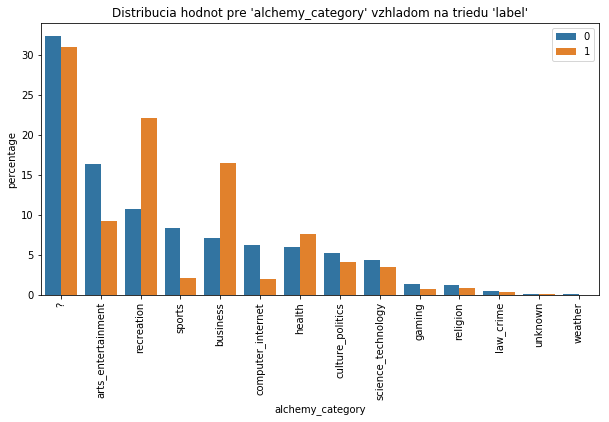

In [23]:
grouped_barplot(df, 'alchemy_category', 'label', title="Distribucia hodnot pre 'alchemy_category' vzhladom na triedu 'label'", size=(10,5), rotation=90)

Tuto si uz mozeme vsimnut rozdiely medzi evergreen a non-evergreen strankami v niektorych kategoriach, najvyraznejsie v kategorii 'recreation' a 'business', kde prevladaju evergreen stranky. V pripade kategorii 'arts_entertainment' a 'sport' naopak prevlada kategoria non-evergreen.

### alchemy_category_score
obsahuje score pridelene alchemy API

**Pozrime sa na atribut 'alchemy_category_score', v prvom kroku na jeho unikatne hodnoty:**

In [24]:
df['alchemy_category_score'].unique()

array(['0.789131', '0.574147', '0.996526', ..., '0.14192', '0.196273',
       '0.617876'], dtype=object)

Hodnoty tohto atributu na prvy pohlad predstavuju desatinne cisla, na zaklade coho by sme predpokladali datovy typ = float64. Ide vsak o object a to z dovodu vyskytu hodnoty '?', ktora je nastavena na tych riadkoch, ktore maju hodnotu '?' aj v atribute 'alchemy_category':

In [25]:
nan_values = df[df['alchemy_category_score'] == '?']
nan_values[['alchemy_category','alchemy_category_score']].head()

,alchemy_category,alchemy_category_score
5,?,?
7,?,?
8,?,?
9,?,?
13,?,?


In [26]:
len_nan = len(nan_values)
len_df = len(df)
percentage = round((len_nan / float(len_df)) * 100, 2)
print('Pocet chybajucich hodnot: ' + str(len_nan) + '\nPocet nastavenych hodnot: ' + str(len_df - len_nan) + '\nCelkovy pocet riadkov: ' + str(len_df) + '\n\nPercentualny podiel chybajucich hodnot: ' + str(percentage) + '%')

Pocet chybajucich hodnot: 2342
Pocet nastavenych hodnot: 5053
Celkovy pocet riadkov: 7395

Percentualny podiel chybajucich hodnot: 31.67%


**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [27]:
# df = df.replace('?', np.nan)  # nahradi v df '?' za nan) asi to staci spustit az v predspracovani, ak treba vobec...

In [28]:
values = df[df['alchemy_category_score'] != '?']
values['alchemy_category_score'] = pd.to_numeric(values['alchemy_category_score'])
values['alchemy_category_score'].describe()

C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    5053.000000
mean        0.603334
std         0.212864
min         0.070833
25%         0.452424
50%         0.625616
75%         0.780851
max         0.999426
Name: alchemy_category_score, dtype: float64

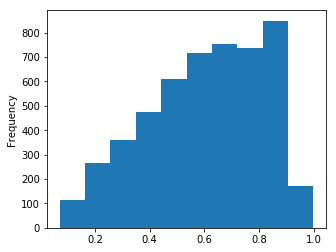

In [29]:
values['alchemy_category_score'].plot(kind = 'hist')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

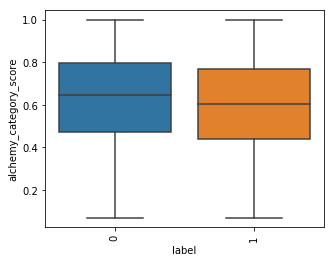

In [30]:
sns.boxplot('label','alchemy_category_score', data=values)
plt.xticks(rotation=90)

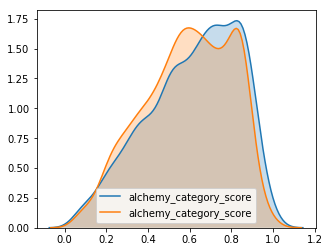

In [31]:
grouped_kdeplot(values, 'alchemy_category_score', 'label')

Tento atribut neukazuje vyrazne rozdiely pre evergreen a non-evergreen stranky.

### avglinksize
Obsahuje priemerny pocet slov v odkazoch na stranke

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [32]:
df['avglinksize'].describe()

count    7395.000000
mean        2.761823
std         8.619793
min         0.000000
25%         1.602062
50%         2.088235
75%         2.627451
max       363.000000
Name: avglinksize, dtype: float64

Tento atribut obsahuje vyrazny extrem 363, tato hodnota pravdepodobne skresli aj grafy

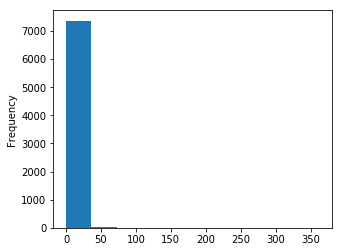

In [33]:
df['avglinksize'].plot(kind = 'hist')

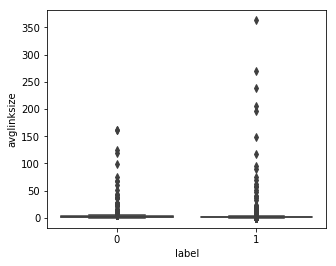

In [34]:
sns.boxplot('label','avglinksize', data=df)

Pre obe hodnoty 'label' je prevazna vacsina hodnot z maleho rozsahu s par desiatok extremnymi hodnotami. Skusime zistit, ci tie extremy mozu byt validne hodnoty:

In [35]:
df[df.avglinksize > 150]

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
929,http://www.mrbreakfast.com/recipe_collection.a...,9201,"{""title"":""Recipes Omelettes Mr Breakfast com ""...",recreation,0.479137,205.500000,0.919192,0.616162,0.326599,0.077441,0.422344,0.000000,0,0.003516,0,0.088064,2.339286,?,1,88,0,1145,297,5,0.872054,0.028674,1
2225,http://www.nikibone.com/recipe/pasta.html,1447,"{""title"":""Nikibone com Pasta Recipes "",""body"":...",business,0.611478,363.000000,0.951807,0.698795,0.385542,0.192771,0.407573,0.000000,0,0.000000,0,0.280532,0.006920,?,1,99,0,12,83,2,0.000000,0.272727,1
2655,http://www.bathandbodyrecipes.com/2/bath-bomb-...,5652,"{""title"":""Bath Bomb Recipes Bath and Body Reci...",culture_politics,0.35859,196.500000,0.887931,0.750000,0.500000,0.189655,0.307150,0.000000,0,0.030844,0,0.157030,1.282051,?,1,78,0,923,116,3,0.000000,0.192661,1
3426,http://www.testsounds.com/,4875,"{""title"":""TestSounds com Pure digital sounds t...",computer_internet,0.410649,269.000000,0.980392,0.980392,0.980392,0.980392,0.266594,0.000000,0,0.038793,0,0.183580,0.017986,?,0,86,0,197,51,0,0.000000,0.023973,1
3437,http://www.nikibone.com/recipe/salsa.html,573,"{""title"":""Nikibone com Salsa Recipes "",""body"":...",arts_entertainment,0.773357,239.000000,0.967742,0.387097,0.096774,0.000000,0.438347,0.000000,0,0.000000,0,0.230232,0.012422,?,0,99,0,12,93,2,0.000000,0.548193,1
5285,http://www.leadingtowar.com/,9793,"{""title"":""Leading To War "",""body"":""ABOUT THE W...",culture_politics,0.433106,161.000000,0.268293,0.219512,0.219512,0.146341,0.756545,0.029851,0,0.055249,0,0.285516,0.298507,?,1,77,0,237,41,0,0.000000,0.059701,0
6185,http://www.voltairenet.org/en,5613,"{""title"":""Voltaire Network "",""body"":""URGENT Sy...",culture_politics,0.860109,161.538462,0.370629,0.262238,0.234266,0.199301,0.575783,0.000000,0,0.004667,0,0.180280,1.416149,1,1,74,0,4101,286,0,0.083916,0.288344,0


Na prvy pohlad nemozeme vyhlasit, ze tieto zaznamy by neboli validne a tym padom by neobsahovali uzitocnu informaciu, preto ich nemozeme jednoducho vyhodit.

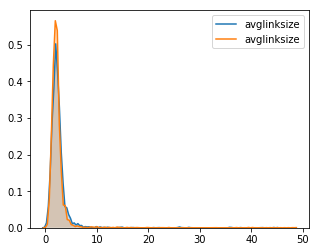

In [36]:
grouped_kdeplot(df[df.avglinksize < 50], 'avglinksize', 'label')
plt.rcParams['figure.figsize'] = (20, 5)

Ani po odstraneni extremnych hodnot sa neukazuje vyrazny rozdiel medzi evergreen a non-evergreen strankami.

### commonlinkratio_1
Pomer vsetkych odkazov na stranke a odkazov ktore zdielaju aspon jedno slovo s ostatnymi odkazmi.

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [37]:
df['commonlinkratio_1'].describe()

count    7395.000000
mean        0.468230
std         0.203133
min         0.000000
25%         0.340370
50%         0.481481
75%         0.616604
max         1.000000
Name: commonlinkratio_1, dtype: float64

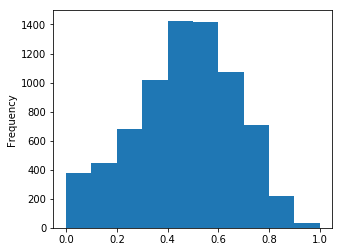

In [38]:
plt.rcParams['figure.figsize'] = (5, 4)
df['commonlinkratio_1'].plot(kind = 'hist')

Atribut ma rozdelenie blizko normalnemu rozdeleniu.

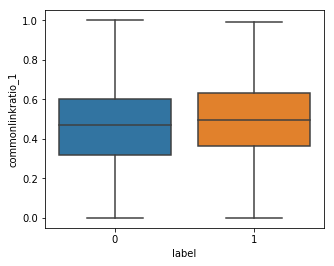

In [39]:
sns.boxplot('label','commonlinkratio_1', data=df)

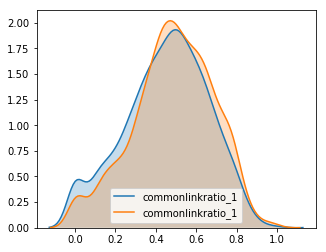

In [40]:
grouped_kdeplot(df, 'commonlinkratio_1', 'label')

Ani v tomto pripade sa nevyskytuje vyrazny rozdiel vzhladom na 'label'.

### commonlinkratio_2
Pomer vsetkych odkazov na stranke a odkazov ktore zdielaju aspon dve slova s ostatnymi odkazmi.

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [41]:
df['commonlinkratio_2'].describe()

count    7395.000000
mean        0.214080
std         0.146743
min         0.000000
25%         0.105263
50%         0.202454
75%         0.300000
max         1.000000
Name: commonlinkratio_2, dtype: float64

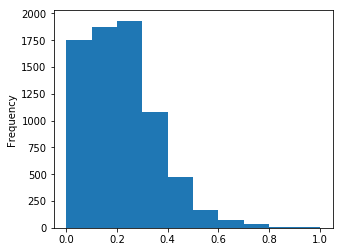

In [42]:
df['commonlinkratio_2'].plot(kind = 'hist')

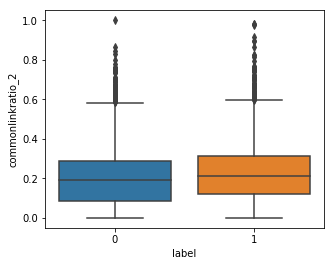

In [43]:
sns.boxplot('label','commonlinkratio_2', data=df)

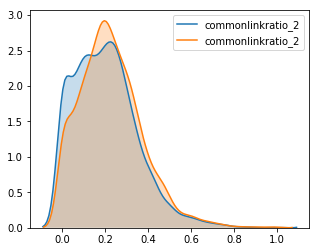

In [44]:
grouped_kdeplot(df, 'commonlinkratio_2', 'label')

Podobny vysledok, ako v pripade commonlinkratio_1.

### commonlinkratio_3
Pomer vsetkych odkazov na stranke a odkazov ktore zdielaju aspon tri slova s ostatnymi odkazmi.

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [45]:
df['commonlinkratio_3'].describe()

count    7395.000000
mean        0.092062
std         0.095978
min         0.000000
25%         0.022222
50%         0.068627
75%         0.133333
max         0.980392
Name: commonlinkratio_3, dtype: float64

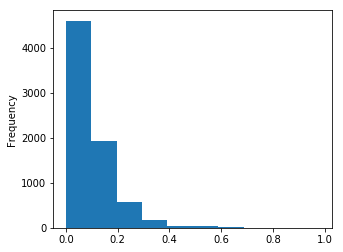

In [46]:
df['commonlinkratio_3'].plot(kind = 'hist')

Tu uz vidime, ze najviac stranok ma malo takych odkazov (alebo vobec), a podiel nad 20% dosiahlo uz len zlomok zo vsetkych stranok.

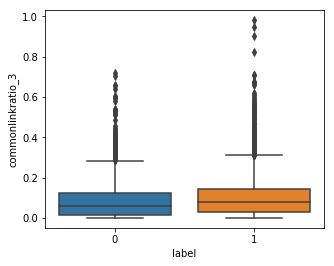

In [47]:
sns.boxplot('label','commonlinkratio_3', data=df)

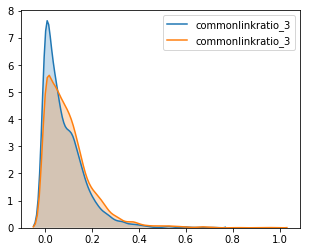

In [48]:
grouped_kdeplot(df, 'commonlinkratio_3', 'label')

V tomto pripade uz mozeme vidiet maly rozdiel, non-evergreen stranky maju vo vseobecnosti o nieco menej odkazov, ktore zdielaju az 3 slova ako evergreen stranky.

### commonlinkratio_4
Pomer vsetkych odkazov na stranke a odkazov ktore zdielaju aspon styri slova s ostatnymi odkazmi.

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [49]:
df['commonlinkratio_4'].describe()

count    7395.000000
mean        0.049262
std         0.072629
min         0.000000
25%         0.000000
50%         0.022222
75%         0.065065
max         0.980392
Name: commonlinkratio_4, dtype: float64

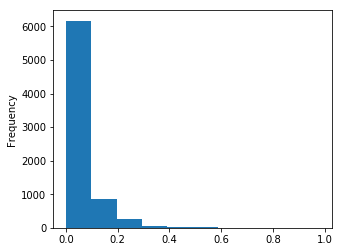

In [50]:
df['commonlinkratio_4'].plot(kind = 'hist')

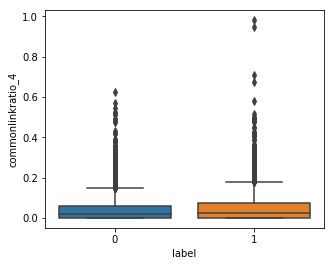

In [51]:
sns.boxplot('label','commonlinkratio_4', data=df)

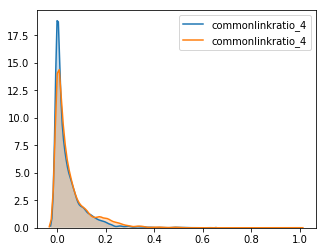

In [52]:
grouped_kdeplot(df, 'commonlinkratio_4', 'label')

### compression_ratio
Dosiahnuta kopresia stranky pomocou gzip

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [53]:
df['compression_ratio'].describe()

count    7395.000000
mean        2.255103
std         5.704313
min         0.000000
25%         0.442616
50%         0.483680
75%         0.578227
max        21.000000
Name: compression_ratio, dtype: float64

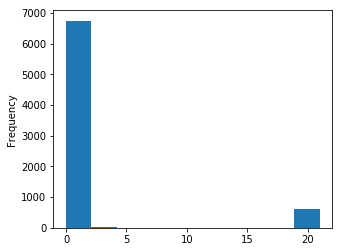

In [54]:
df['compression_ratio'].plot(kind = 'hist')

Tento atribut vyzera byt rozdeleny do dvoch skupin, vacsia skupina pri hodnote 0 a druha okolo hodnoty 20

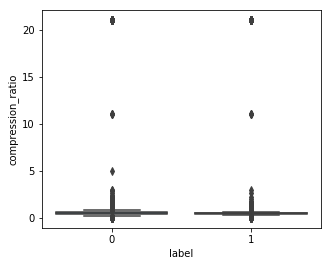

In [55]:
sns.boxplot('label','compression_ratio', data=df)

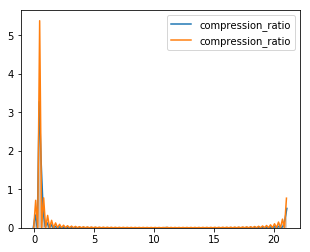

In [56]:
grouped_kdeplot(df, 'compression_ratio', 'label')

Z pohladu labelov nema tento atribut vyraznu pomocnu informaciu.

### embed_ratio
Count of number of < embed>  usage

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [57]:
df['embed_ratio'].describe()

count    7395.000000
mean       -0.103750
std         0.306545
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.250000
Name: embed_ratio, dtype: float64

Atribut obsahuje hodnoty = **-1**, co moze predstavovat ciselnu reprezentaciu pre **nan**

In [58]:
df.embed_ratio.value_counts()

 0.000000    6138
-1.000000     774
 0.027778       6
 0.028571       6
 0.011364       5
 0.071429       4
 0.027027       4
 0.009615       4
 0.032258       4
 0.100000       4
 0.019608       4
 0.083333       4
 0.003367       3
 0.018182       3
 0.009901       3
 0.018519       3
 0.004587       3
 0.010000       3
 0.011494       3
 0.066667       3
 0.008475       3
 0.005076       3
 0.006579       3
 0.010309       3
 0.006711       3
 0.016949       3
 0.007407       3
 0.001522       3
 0.001931       3
 0.040000       3
             ... 
 0.013514       1
 0.000610       1
 0.001053       1
 0.001969       1
 0.003534       1
 0.001068       1
 0.008929       1
 0.002222       1
 0.005714       1
 0.006289       1
 0.002959       1
 0.002541       1
 0.020000       1
 0.024752       1
 0.058824       1
 0.002078       1
 0.001597       1
 0.003170       1
 0.001582       1
 0.001092       1
 0.009091       1
 0.016667       1
 0.001267       1
 0.002653       1
 0.005236 

Atribut taktiez obsahuje velke mnozstvo **nulovych hodnot**.

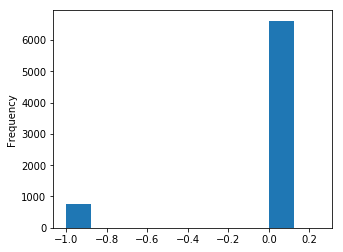

In [59]:
df['embed_ratio'].plot(kind = 'hist')

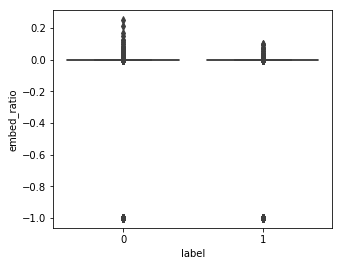

In [60]:
sns.boxplot('label','embed_ratio', data=df)

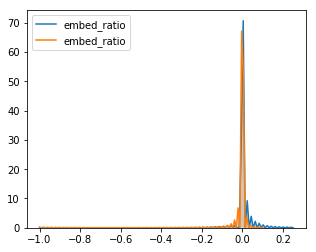

In [61]:
grouped_kdeplot(df, 'embed_ratio', 'label')

Z pohladu labelov nema ani tento atribut vyraznu pomocnu informaciu.

### framebased
obsahuje 1/0 hodnoty, ci stranka je frame-based (nema ziaden body markup, ale ma frameset markup)

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [62]:
df['framebased'].describe()

count    7395.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: framebased, dtype: float64

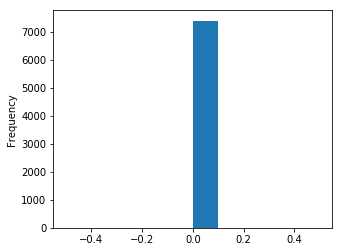

In [63]:
df['framebased'].plot(kind = 'hist')

Atribut obsahuje len nulove hodnoty.

### frameTagRatio
pomer iframe markupov voci celkovemu poctu markupov

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [64]:
df['frameTagRatio'].describe()

count    7395.000000
mean        0.056423
std         0.041446
min         0.000000
25%         0.028502
50%         0.045775
75%         0.073459
max         0.444444
Name: frameTagRatio, dtype: float64

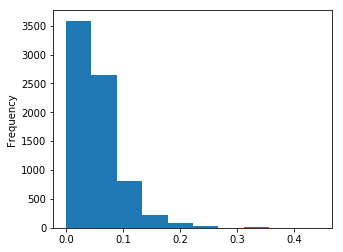

In [65]:
df['frameTagRatio'].plot(kind = 'hist')

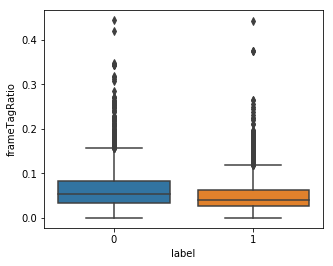

In [66]:
sns.boxplot('label','frameTagRatio', data=df)

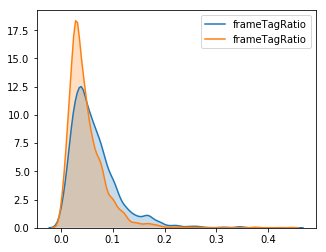

In [67]:
grouped_kdeplot(df, 'frameTagRatio', 'label')

Z pohladu labelov mozeme vnimat urcitu uroven separovatelnosti vzhladom na hodnoty tohto atributu.

### hasDomainLink
obsahuje True/False hodnoty, ci stranka obsahuje odkaz s domain adresou

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [68]:
df['hasDomainLink'].unique()

array([0, 1], dtype=int64)

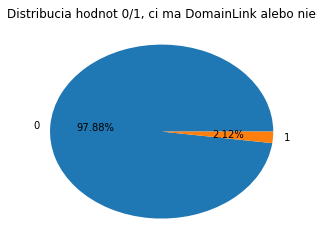

In [69]:
pie_plot(df, 'hasDomainLink', title='Distribucia hodnot 0/1, ci ma DomainLink alebo nie')

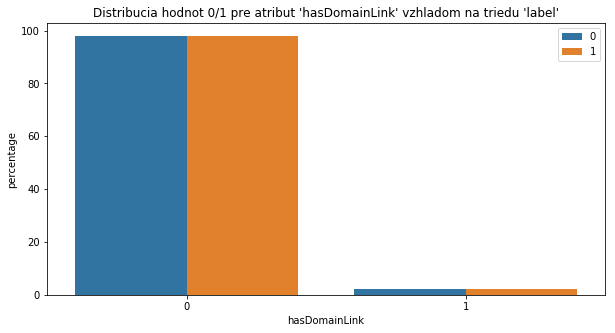

In [70]:
grouped_barplot(df, 'hasDomainLink', 'label', title="Distribucia hodnot 0/1 pre atribut 'hasDomainLink' vzhladom na triedu 'label'", size=(10,5))

Tento atribut ma rovnake rozdelenie pre oba labely.

### html_ratio
pomer html elementov voci textu

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [71]:
df['html_ratio'].describe()

count    7395.000000
mean        0.233778
std         0.052487
min         0.045564
25%         0.201061
50%         0.230564
75%         0.260770
max         0.716883
Name: html_ratio, dtype: float64

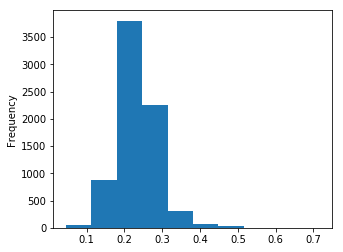

In [72]:
df['html_ratio'].plot(kind = 'hist')

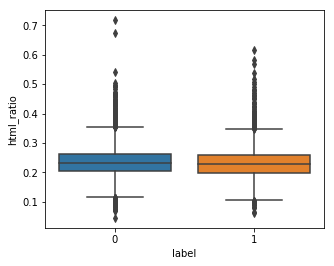

In [73]:
sns.boxplot('label','html_ratio', data=df)

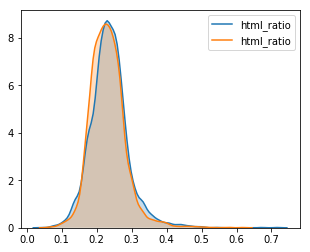

In [74]:
grouped_kdeplot(df, 'html_ratio', 'label')

Z pohladu labelov nema ani tento atribut vyraznu pomocnu informaciu.

### image_ratio

pomer obrazkov voci textu na stranke

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [75]:
df['image_ratio'].describe()

count    7395.000000
mean        0.275709
std         1.919320
min        -1.000000
25%         0.025900
50%         0.083051
75%         0.236700
max       113.333333
Name: image_ratio, dtype: float64

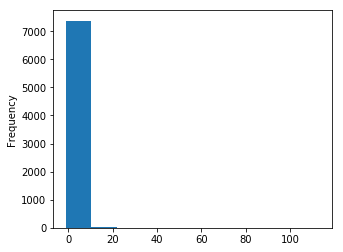

In [76]:
df['image_ratio'].plot(kind = 'hist')

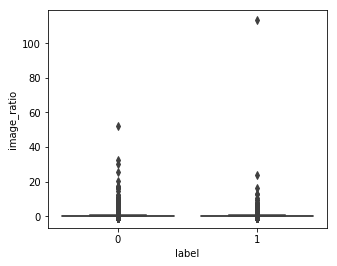

In [77]:
sns.boxplot('label','image_ratio', data=df)

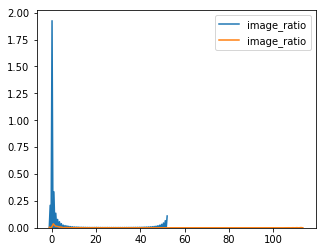

In [78]:
grouped_kdeplot(df, 'image_ratio', 'label')

Z pohladu labelov mozeme vnimat mensiu mieru separovatelnosti vzhladom na hodnoty tohto atributu.

### is_news

Obsahuje True/false hodnoty podla StumbleUpon's news classifier: 1- ak klasifikator vyhodnotilo, ze stranka obsahuje spravy (news), 0- inak

In [79]:
df['is_news'].unique()

array(['1', '?'], dtype=object)

Otaznik pravdepodobne znaci chybajuce hodnoty

In [80]:
nan_values = df[df['is_news'] == '?']

len_nan = len(nan_values)
len_df = len(df)
percentage = round((len_nan / float(len_df)) * 100, 2)
print('Pocet chybajucich hodnot: ' + str(len_nan) + '\nPocet nastavenych hodnot: ' + str(len_df - len_nan) + '\nCelkovy pocet riadkov: ' + str(len_df) + '\n\nPercentualny podiel chybajucich hodnot: ' + str(percentage) + '%')

Pocet chybajucich hodnot: 2843
Pocet nastavenych hodnot: 4552
Celkovy pocet riadkov: 7395

Percentualny podiel chybajucich hodnot: 38.44%


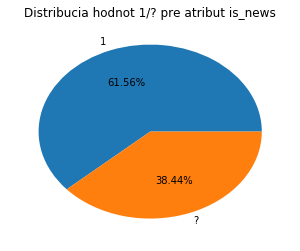

In [81]:
pie_plot(df, 'is_news', title='Distribucia hodnot 1/? pre atribut is_news')

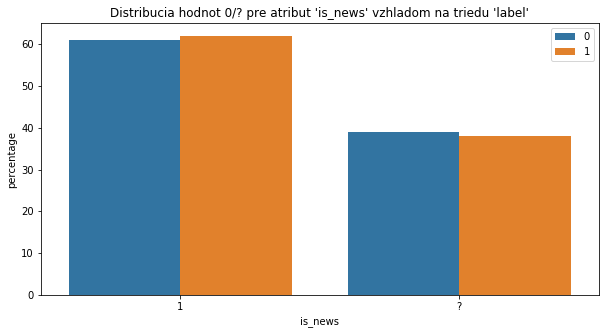

In [82]:
grouped_barplot(df, 'is_news', 'label', title="Distribucia hodnot 0/? pre atribut 'is_news' vzhladom na triedu 'label'", size=(10,5))

Hodnoty tohto atributu maju takmer rovnake rozdelenie pre oba labely.

### lengthyLinkDomain

Obsahuje informaciu, ci aspon tri odkazy na stranke obsahuju viac ako 30 znakov (1- True, 0- false)

**Pozrime sa na rozdelenie unikatnych hodnot tohto atributu:**

In [83]:
df['lengthyLinkDomain'].unique()

array([1, 0], dtype=int64)

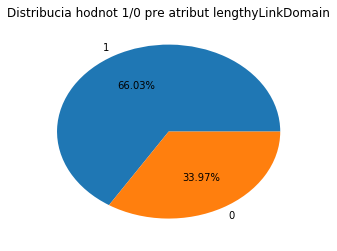

In [84]:
pie_plot(df, 'lengthyLinkDomain', title='Distribucia hodnot 1/0 pre atribut lengthyLinkDomain')

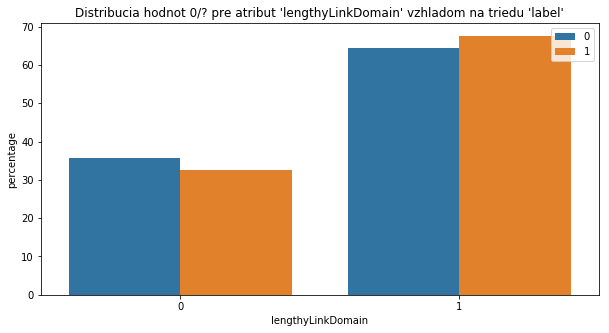

In [85]:
grouped_barplot(df, 'lengthyLinkDomain', 'label', title="Distribucia hodnot 0/? pre atribut 'lengthyLinkDomain' vzhladom na triedu 'label'", size=(10,5))

Vyskytuju sa mierne rozdiely medzi hodnotami jednotlivych atributov vzhladom na label.

### linkwordscore 

Percento slov, ktore su v hyperlinkoch na stranke

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [86]:
df['linkwordscore'].describe()

count    7395.000000
mean       30.077079
std        20.393101
min         0.000000
25%        14.000000
50%        25.000000
75%        43.000000
max       100.000000
Name: linkwordscore, dtype: float64

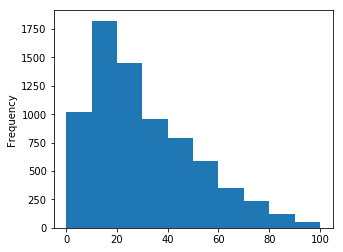

In [87]:
df['linkwordscore'].plot(kind = 'hist')

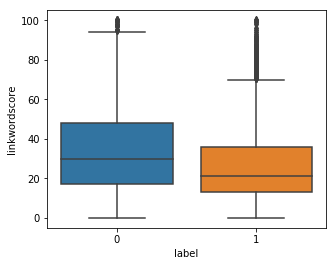

In [88]:
sns.boxplot('label','linkwordscore', data=df)

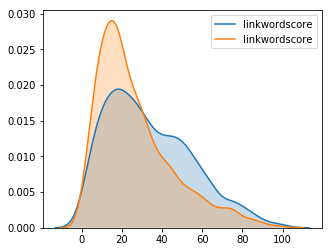

In [89]:
grouped_kdeplot(df, 'linkwordscore', 'label')

V tomto pripade mozeme vidiet maly rozdiel v pripade vyssich hodnot, kde prevladaju non-evergreen stranky.

### news_front_page

Obsahuje hodnotu True(1), ak StumbleUpon's news classifier rozhodne o stranke, ze je front-page news

**Pozrime sa na atribut 'news_front_page', v prvom kroku na jeho unikatne hodnoty:**

In [90]:
uniques = df['news_front_page'].unique()
print('Unikatne hodnoty pre news_front_page:\n' + str(uniques) + '\n')
print('Pocet unikatnych hodnot pre news_front_page: ' + str(len(uniques)))

Unikatne hodnoty pre news_front_page:
['0' '?' '1']

Pocet unikatnych hodnot pre news_front_page: 3


Medzi unikatnymi hodnotami atributu 'news_front_page' sa vyskytuje hodnota '?', ktora s najvacsou pravdepodobnostou reprezentuje hodnotu Nan.

**Pozrime sa na pocetnosti jednotlivych hodnot atributu:**

In [91]:
pd.crosstab(df['news_front_page'], df.label)

label,0,1
news_front_page,,
0,2814,3039
1,156,138
?,629,619


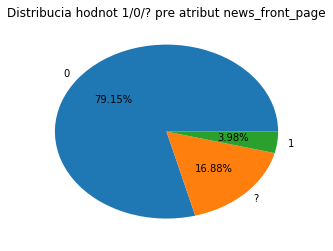

In [92]:
pie_plot(df, 'news_front_page', title='Distribucia hodnot 1/0/? pre atribut news_front_page')

**Pozrime sa na rozdelenie jednotlivych hodnot vzhladom na hodnotu labelu:**

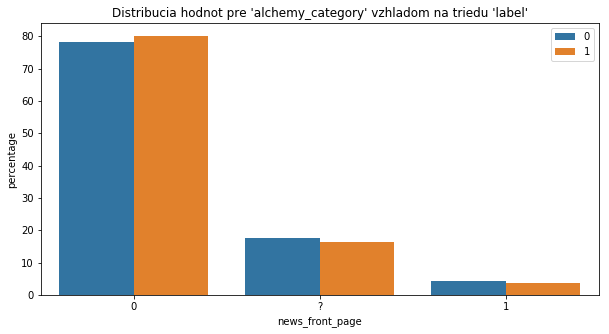

In [93]:
grouped_barplot(df, 'news_front_page', 'label', title="Distribucia hodnot pre 'alchemy_category' vzhladom na triedu 'label'", size=(10,5))

Mozeme si vsimnut len minimalne rozdiely v zastupeni jednotlivych hodnot vzhladom na label.

### non_markup_alphanum_characters

pocet alfanumerickych znakov na stranke

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [94]:
df['non_markup_alphanum_characters'].describe()

count      7395.000000
mean       5716.598242
std        8875.432430
min           0.000000
25%        1579.000000
50%        3500.000000
75%        6377.000000
max      207952.000000
Name: non_markup_alphanum_characters, dtype: float64

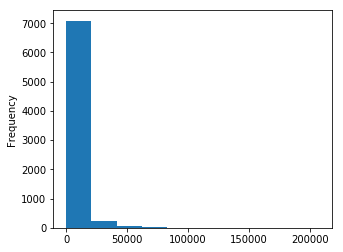

In [95]:
df['non_markup_alphanum_characters'].plot(kind = 'hist')

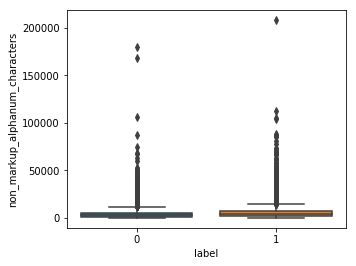

In [96]:
sns.boxplot('label','non_markup_alphanum_characters', data=df)

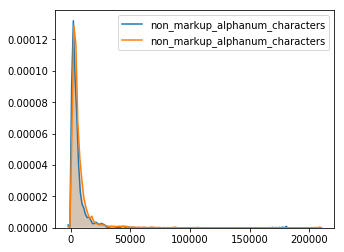

In [97]:
grouped_kdeplot(df, 'non_markup_alphanum_characters', 'label')

Pre oba labely mame velmi podobne rozdelenie.

### numberOfLinks

pocet < a> tagov na stranke

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [98]:
df['numberOfLinks'].describe()

count    7395.000000
mean      178.754564
std       179.466198
min         1.000000
25%        82.000000
50%       139.000000
75%       222.000000
max      4997.000000
Name: numberOfLinks, dtype: float64

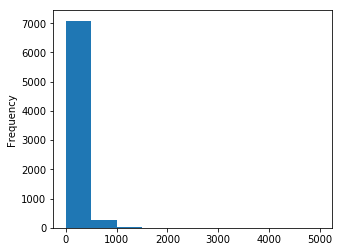

In [99]:
df['numberOfLinks'].plot(kind = 'hist')

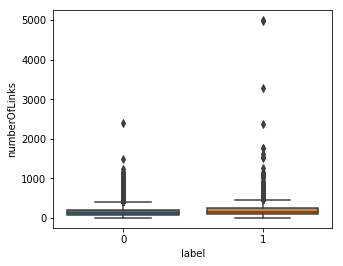

In [100]:
sns.boxplot('label','numberOfLinks', data=df)

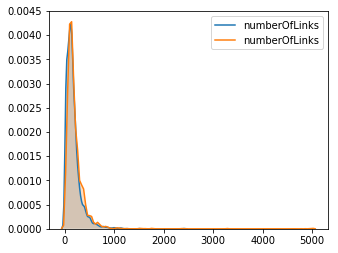

In [101]:
grouped_kdeplot(df, 'numberOfLinks', 'label')

Nie su skoro ziadne rozdiely medzi labelmi.

### numwords_in_url

pocet slov v url

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [102]:
df['numwords_in_url'].describe()

count    7395.000000
mean        4.960649
std         3.233111
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        22.000000
Name: numwords_in_url, dtype: float64

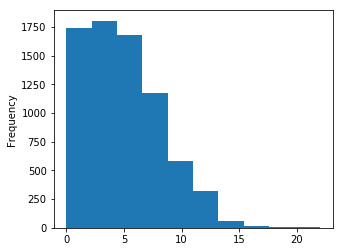

In [103]:
df['numwords_in_url'].plot(kind = 'hist')

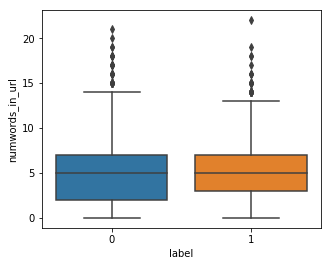

In [104]:
sns.boxplot('label','numwords_in_url', data=df)

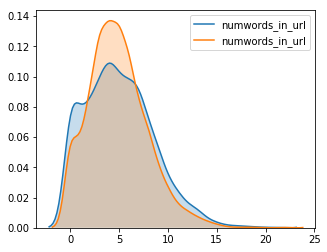

In [105]:
grouped_kdeplot(df, 'numwords_in_url', 'label')

Pre evergreen stranky je typickejsie pocet slov okolo 5, ako pre non-evergreen stranky.

### parametrizedLinkRatio
Podiel parametrizovanych linkov (linka je parametrizovana, ak jej url obsahuje parametre alebo je pridelena k onClick event-u)

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [106]:
df['parametrizedLinkRatio'].describe()

count    7395.000000
mean        0.172864
std         0.183286
min         0.000000
25%         0.040984
50%         0.113402
75%         0.241299
max         1.000000
Name: parametrizedLinkRatio, dtype: float64

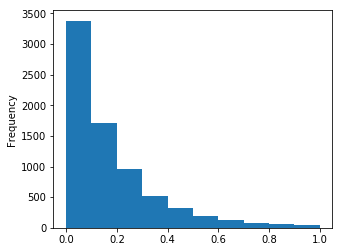

In [107]:
df['parametrizedLinkRatio'].plot(kind = 'hist')

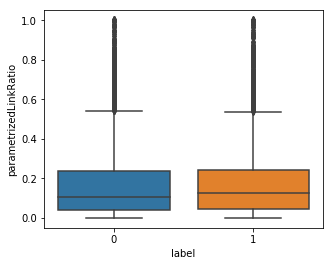

In [108]:
sns.boxplot('label','parametrizedLinkRatio', data=df)

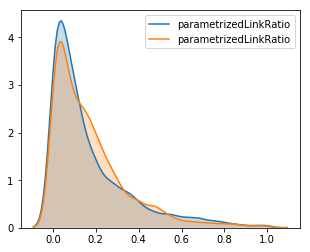

In [109]:
grouped_kdeplot(df, 'parametrizedLinkRatio', 'label')

Vidime len minimalne rozdiely medzi labelmi.

### spelling_errors_ratio

podiel slov nenajdenych v slovniku (predpokladane pravopisne chyby a preklepy)

**Pozrime sa na rozdelenie numerickych hodnot tohto atributu:**

In [110]:
df['spelling_errors_ratio'].describe()

count    7395.000000
mean        0.101221
std         0.079231
min         0.000000
25%         0.068739
50%         0.089312
75%         0.112376
max         1.000000
Name: spelling_errors_ratio, dtype: float64

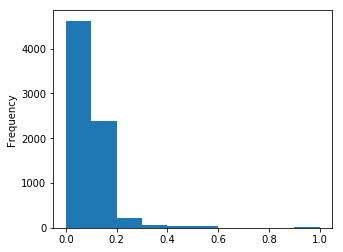

In [111]:
df['spelling_errors_ratio'].plot(kind = 'hist')

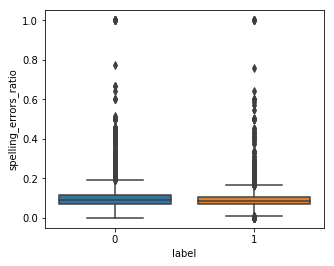

In [112]:
sns.boxplot('label','spelling_errors_ratio', data=df)

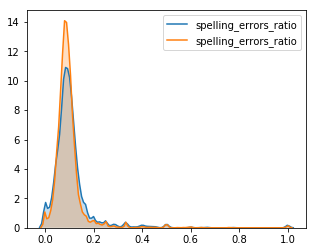

In [113]:
grouped_kdeplot(df, 'spelling_errors_ratio', 'label')

Vidime tiez len minimalny rozdiel vzhladom na label.

## Zhrnutie informacii o atributoch

Vacsina atributov neobsahuje vyrazne napomocnu informaciu o strankach, co by pomohlo urcit ich zaradenie do evergreen alebo nie. Pre tieto ucely nam moze pomoct v najvacsej miere pravdepodobne samotny text stranky.

Napomocny by mohol byt tiez atribut 'alchemy_category', ktora urcuje typy stranok, v tomto pripade moze byt problem, ze je pomerne vela chybajucich hodnot.

In [114]:
df.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

## Rozdelenie atributov do dvoch skupin

Dataset neobsahuje jasne a prirodzene oddelitelne podmnoziny vlastnosti, hociako sa rozhodneme atributy rozdelit, nejaka suvislost medzi mnozinami tam nutne ostane.

Jeden pristup by mohol byt oddelenie atributov, ktore hovoria o odkazoch (avglinksize, commonlinkration1-4,hasDomainLink,lengthyLinkDomain,linkwordscore,numberOfLinks, numwords_in_url, parametrizedLinkRatio) od ostatnych atributov, ktore hovoria skor o obsahu stranky.

Druhou moznostou by mohlo byt rozdelenie podla toho, ci dany atribut je v suvislosti s textom/obsahom stranky ('boilerplate', 'alchemy_category',
       'alchemy_category_score','is_news',news_front_page', 'non_markup_alphanum_characters', 'spelling_errors_ratio'), alebo skor s html kodom s obrazkami a pod.

Potrebujeme ziskat odhad, ci na zaklade atributov z jednoltlivych skupin je mozne predikovat label stranky s prijatelnou uspesnostou.

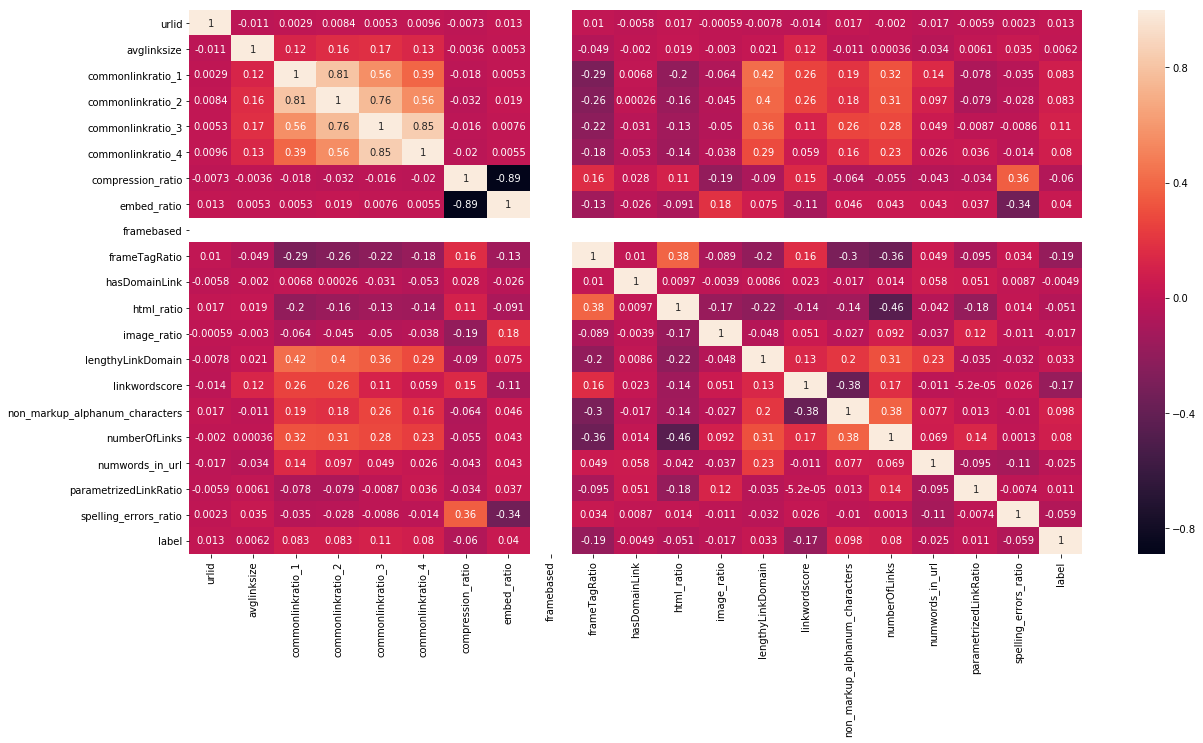

In [115]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, ax = ax) 

In [116]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns

Index(['urlid', 'avglinksize', 'commonlinkratio_1', 'commonlinkratio_2',
       'commonlinkratio_3', 'commonlinkratio_4', 'compression_ratio',
       'embed_ratio', 'framebased', 'frameTagRatio', 'hasDomainLink',
       'html_ratio', 'image_ratio', 'lengthyLinkDomain', 'linkwordscore',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

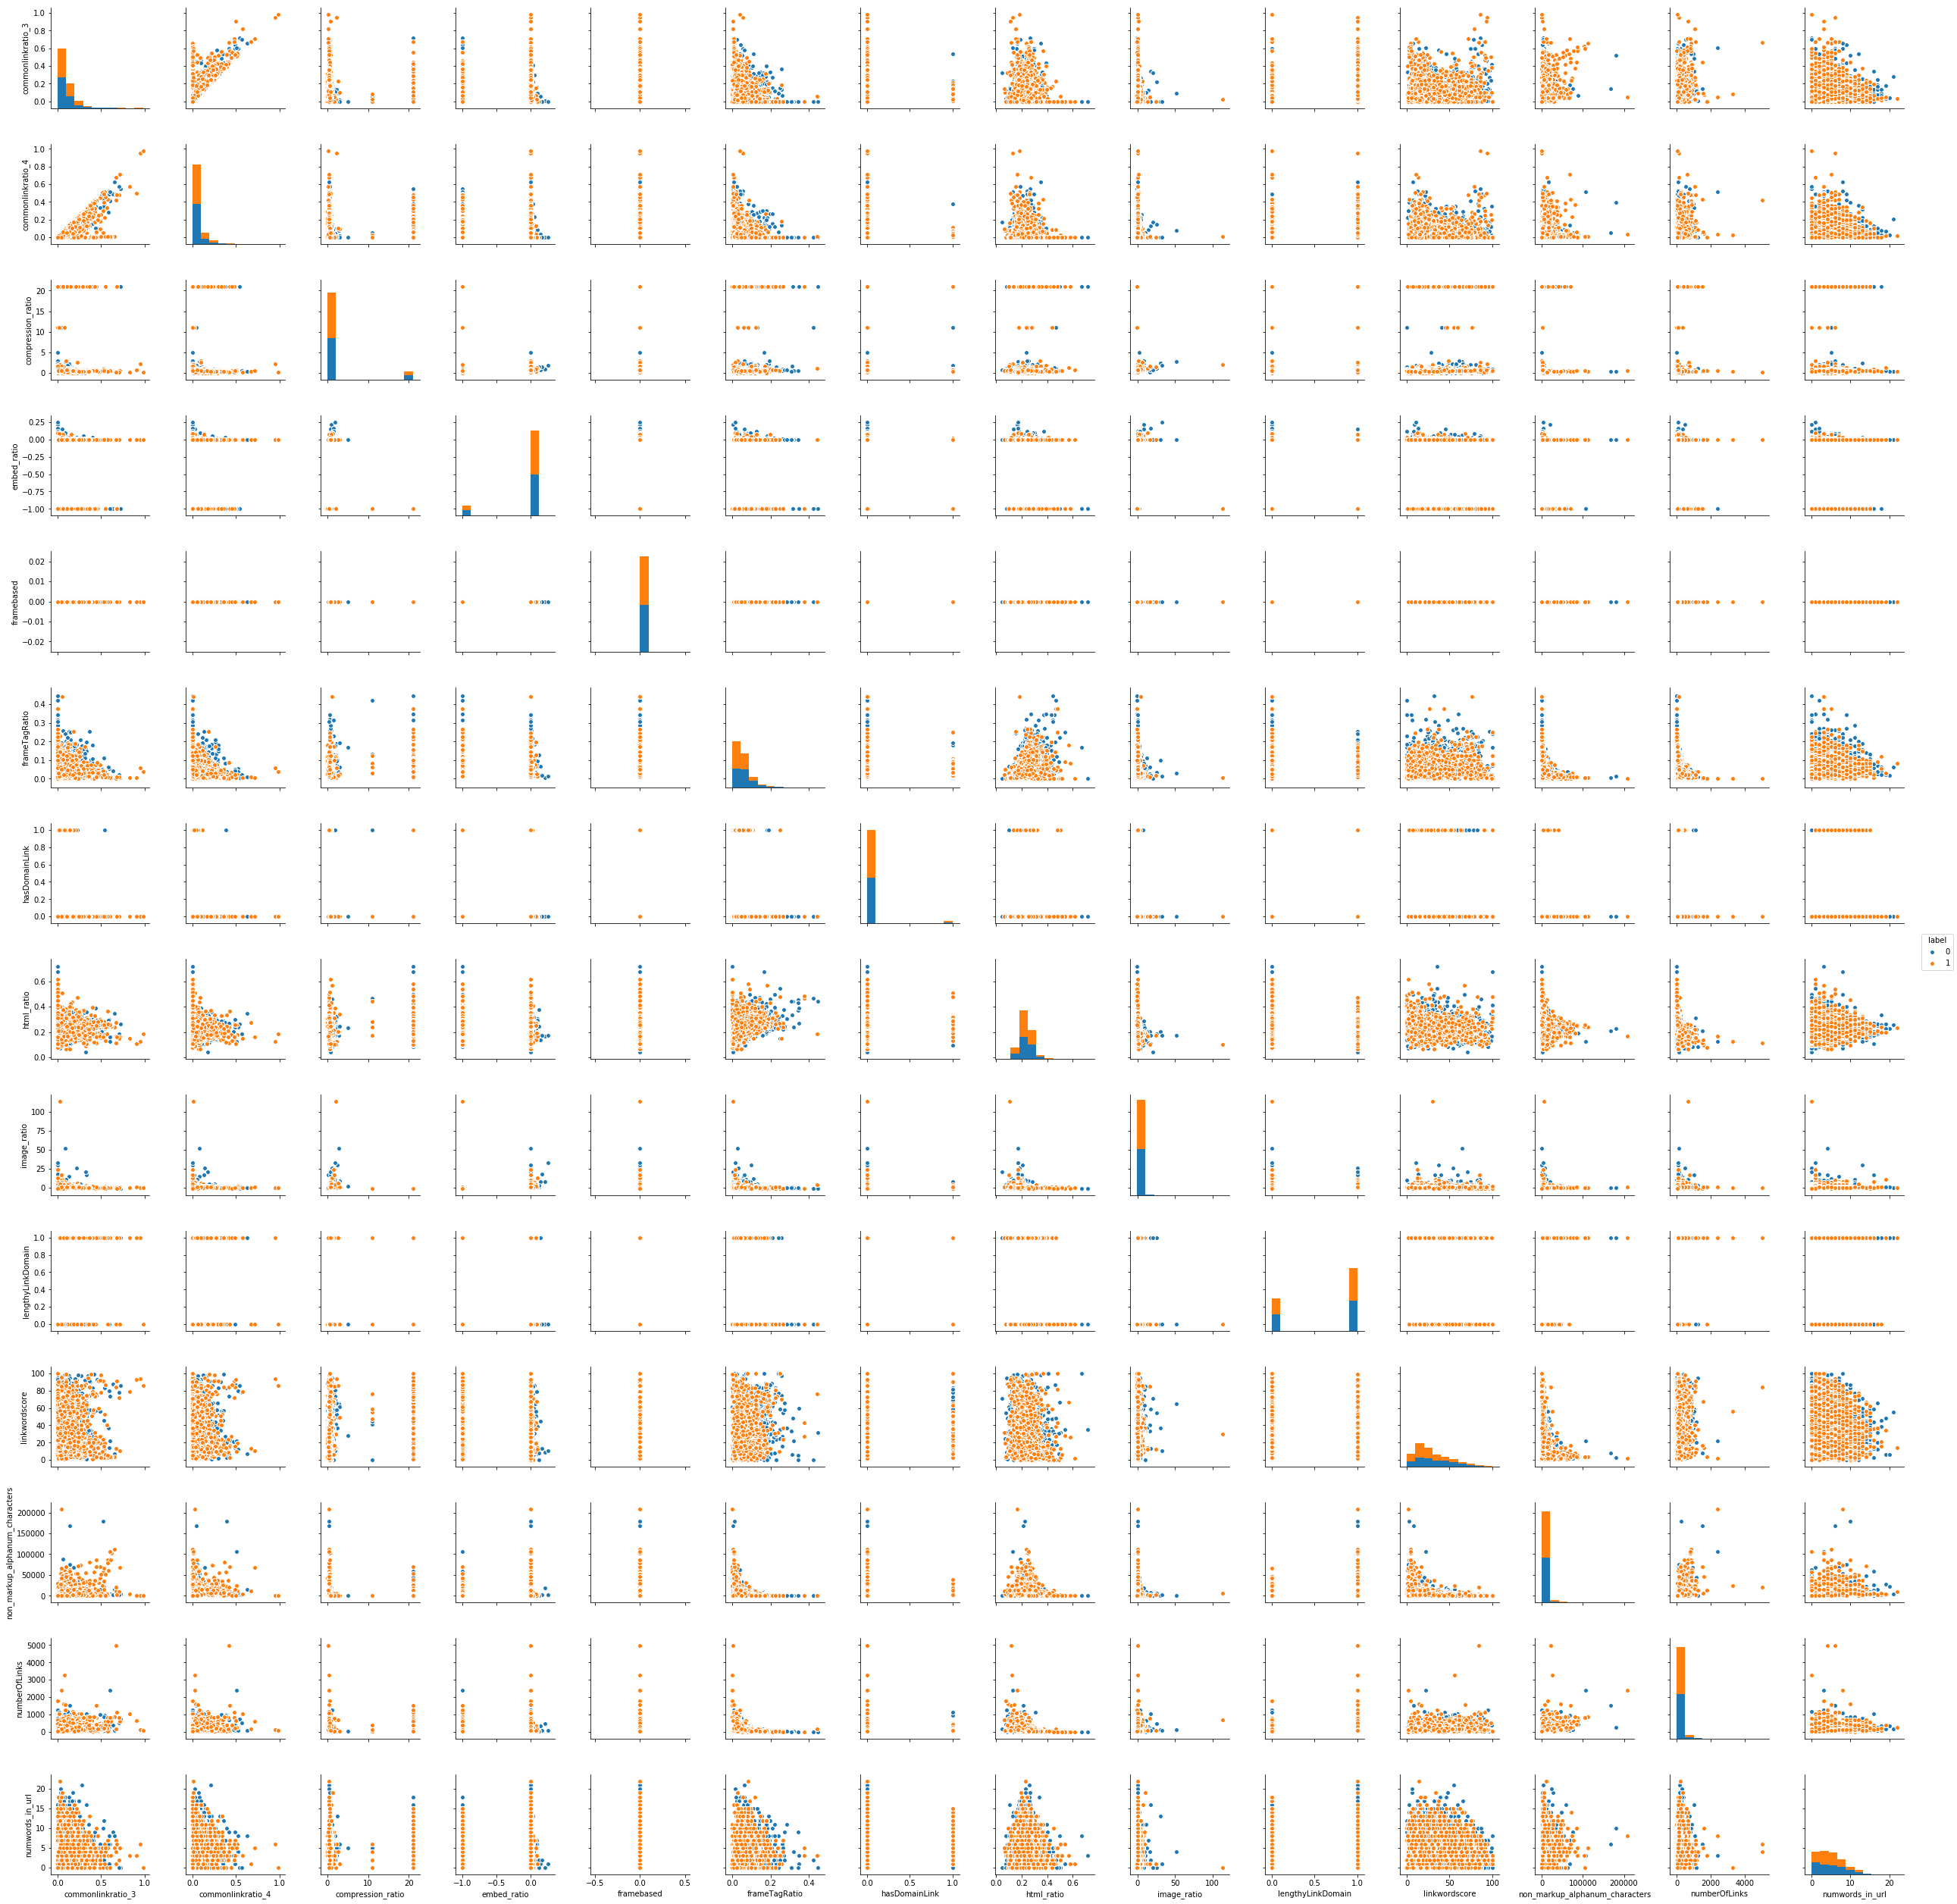

In [117]:
columns = [u'commonlinkratio_3', u'commonlinkratio_4', u'compression_ratio',
       u'embed_ratio', u'framebased', u'frameTagRatio', u'hasDomainLink',
       u'html_ratio', u'image_ratio', u'lengthyLinkDomain', u'linkwordscore',
       u'non_markup_alphanum_characters', u'numberOfLinks', u'numwords_in_url']
sns.pairplot(df, vars=columns, hue='label')

Z pairplotov nevidime v ziadnej kombinacii dvojiciek atributov jasne oddelenie evergreen a non-evergreen stranok, body sa v znacnej miere prekryvaju.

## Analyza textovych atributov

Dalsi zaujimavy pohlad by mohol byt na textove atributy, konkretne obsah stranky.

In [6]:
import nltk
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords

Najskor predspracujeme text. Ziskame ho z atributu boilerplate:

In [7]:
df['body_content'] = df['boilerplate'].apply(lambda x: json.loads(x)['body'])

Teraz odstranime vsetky znaky, ktore nie su znaky slov. Pouzijeme na to regularne vyrazy:

In [8]:
df['body_content'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [9]:
df['body_content'] = df['body_content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))

Este ako male upravy, aby nas slovnik obsahoval kazde slovo len raz, dame ich vsetky na lowercase a rozdelime texty na slova, aby sme ich nasledne mohli spracovat:

In [10]:
df['body_content'] = df['body_content'].apply(lambda x: str(x).lower().split())

Teraz potrebujeme este odstranit slova, ktore nedavaju vyznam. O jednom raze prevedieme slova na ich korenovy zaklad pouzitim stemmingu:

In [11]:
porter_stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

In [12]:
df['body_content'] = df['body_content'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

Teraz uz mame vsetky slova pripravene, uz ich len naspat spojime do jednej suvislej vety, aby s nimi vedeli lahsie pracovat algoritmy spracovania textu:

In [13]:
df['body_content_final'] = df['body_content'].apply(lambda x: ' '.join(x))

### Bag of words

Jeden z pristupov je pouzit bag of words, reprezentovat kazde slovo ako jeden atribut, pricom hodnota pre zaznam urcuje, ci sa slovo nachadza v texte a kolkokrat.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
cv = CountVectorizer()

In [14]:
bow = cv.fit_transform(df['body_content_final']).toarray()

### TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tv = TfidfVectorizer()

In [17]:
tf_idf = tv.fit_transform(df['body_content_final']).toarray()

### Atribut URL

In [15]:
df['url_new'] = df['url'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))
df['url_new'] = df['url_new'].apply(lambda x: str(x).lower().split())

In [16]:
df['url_new'] = df['url_new'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

In [17]:
df['url_final'] = df['url_new'].apply(lambda x: ' '.join(x))

In [18]:
tv_url = TfidfVectorizer(max_features = 1000)
tf_idf_url = tv_url.fit_transform(df['url_final']).toarray()

## Vytvaranie modelov

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms

In [23]:
df.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label',
       'body_content', 'body_content_final', 'url_new', 'url_final'],
      dtype='object')

### Vyber numerickych atributov

Vyberieme urcitu mnozinu relevantnych numerickych atributov na zaklade predoslej analyzy

In [20]:
feature_set_1_1 = ['avglinksize', 'commonlinkratio_1', 'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
                   'hasDomainLink','lengthyLinkDomain','linkwordscore','numberOfLinks',
                   'numwords_in_url', 'parametrizedLinkRatio']

In [71]:
y = df.label
X = df.loc[:,feature_set_1_1]

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
X_train.shape

(5916, 11)

In [144]:
X_test.shape

(1479, 11)

In [145]:
scaler = StandardScaler()

transformed_train = scaler.fit_transform(X_train)
transformed_test = scaler.transform(X_test)

### Predikovanie na zaklade numerickych atributov

##### Logistic regression

In [139]:
lg = LogisticRegression()
lg.fit(transformed_train,y_train)
pred = lg.predict(transformed_test)

In [140]:
accuracy_score(y_test, pred)

0.5956727518593644

##### Naive Bayes

In [141]:
gnb = GaussianNB()
gnb.fit(transformed_train,y_train)
pred_g = gnb.predict(transformed_test)

In [142]:
accuracy_score(y_test, pred_g)

0.5611899932386748

##### Random forest

In [143]:
clf = RandomForestClassifier(n_estimators=300, max_depth=15,
                              random_state=10)
clf.fit(transformed_train,y_train)
pred_c= clf.predict(transformed_test)

In [144]:
accuracy_score(y_test, pred_c)

0.6639621365787695

### Predikovanie na zaklade textovych atributov - text stranky (bow, TF-IDF)

##### Gausian naive bayes (bow)

In [145]:
y = df.label
X = bow

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
gnb = GaussianNB()

In [147]:
gnb.fit(X_train,y_train)
pred = gnb.predict(X_test)

In [148]:
accuracy_score(y_test, pred)

0.6605814739688979

In [149]:
lg = LogisticRegression()
lg.fit(X_train,y_train)
pred = lg.predict(X_test)

In [150]:
accuracy_score(y_test, pred)

0.7505070993914807

##### Random forest (bow)

In [151]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=20,
                              random_state=10)

In [152]:
clf.fit(X_train,y_train)
pred_clf = clf.predict(X_test)

In [153]:
accuracy_score(y_test, pred_clf)

0.7903989181879648

##### Random forest (TF-IDF)

In [154]:
y_tf = df.label
X_tf = tf_idf

X_train_tf, X_test_tf, y_train_tf, y_test_tf = ms.train_test_split(X_tf, y_tf, test_size=0.2, random_state=42)

In [155]:
clf_tfidf = RandomForestClassifier(n_estimators=1000, max_depth=20,
                              random_state=10)

In [156]:
clf_tfidf.fit(X_train_tf,y_train_tf)
pred_tf = clf_tfidf.predict(X_test_tf)

In [157]:
accuracy_score(y_test_tf, pred_tf)

0.7883705206220419

**Zvysenie poctu stromov:**

In [158]:
clf_tfidf = RandomForestClassifier(n_estimators=2000, max_depth=20,
                              random_state=10)

In [159]:
clf_tfidf.fit(X_train_tf,y_train_tf)
pred_tf = clf_tfidf.predict(X_test_tf)

In [160]:
accuracy_score(y_test_tf, pred_tf)

0.7876943881000676

### TF-IDF - top 1000

1000 najfrekventovanejsich slov pomocou **TF-IDF**:

In [21]:
tv2 = TfidfVectorizer(max_features = 1000)
tf_idf_1000 = tv2.fit_transform(df['body_content_final']).toarray()

In [22]:
y_max = df.label
X_max = tf_idf_1000

X_train_max, X_test_max, y_train_max, y_test_max = ms.train_test_split(X_max, y_max, test_size=0.2, random_state=42)

In [23]:
clf_max = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)

In [24]:
clf_max.fit(X_train_max,y_train_max)
pred_tf = clf_max.predict(X_test_max)

In [25]:
accuracy_score(y_test_max, pred_tf)

0.7971602434077079

### Overovanie nezavislosti mnozin atributov

V tejto casti sa pokusime o overenie nezavislosti medzi nami zvolenymi podmnozinami atributov, s ktorymi budu pracovat jednotlive klasifikatori (2) v procese co-traingu.

Sposob overenia spociva v predikovani labelu klasifikatormi, ktore predikuju len na zaklade im pridelenej podmoziny atributov, naslednom vybrati riadkov na zaklade istoty predikcie, ktora je >= ako zvoleny threshold. Nasledne overime do akej miery vznikol prekryv medzi vybranymi riadkami.

#### Vytvorenie klasifikatorov
V prvom kroku vytvorime klasifikatory, pouzivat budeme klasifikator *Random Forest*:

In [274]:
clf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=8,
                              random_state=10)
clf_numerical = RandomForestClassifier(n_estimators=100, max_depth=8,
                              random_state=10)

#### Upravenie dat pre klasifikatory

- pre numericky klasifikator vyberieme cast dataframe-u zodpovedajucu vybranym numerickym atributom
- pre textovy klasifikator pouzijeme TOP 1000 TF-IDF slov 

In [275]:
y = df.label

X_numerical = df.loc[:,feature_set_1_1]

tv2 = TfidfVectorizer(max_features = 1000)
X_tfidf = tv2.fit_transform(df['body_content_final']).toarray()

In [276]:
X_numerical.head()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,hasDomainLink,lengthyLinkDomain,linkwordscore,numberOfLinks,numwords_in_url,parametrizedLinkRatio
0,2.055556,0.676471,0.205882,0.047059,0.023529,0,1,24,170,8,0.152941
1,3.677966,0.508021,0.288770,0.213904,0.144385,0,1,40,187,9,0.181818
2,2.382883,0.562016,0.321705,0.120155,0.042636,0,1,55,258,11,0.166667
3,1.543103,0.400000,0.100000,0.016667,0.000000,0,0,24,120,5,0.041667
4,2.676471,0.500000,0.222222,0.123457,0.043210,0,1,14,162,10,0.098765


In [277]:
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.06458285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Fitovanie modelov a zistovanie istoty predikcii

Fitovanie numerickeho modelu a zistovanie istoty predikcii:

In [278]:
model_numerical = clf_numerical.fit(X_numerical, y)
class_probabilities_numerical = model_numerical.predict_proba(X_numerical)

Fitovanie TF-IDF modelu a zistovanie istoty predikcii:

In [279]:
model_tfidf = clf_tfidf.fit(X_tfidf, y)
class_probabilities_tfidf = model_tfidf.predict_proba(X_tfidf)

Hodnoty predikovanej triedy a nahlad istoty pre predikciu triedy pre dane riadky:

In [280]:
model_numerical.classes_

array([0, 1], dtype=int64)

In [281]:
class_probabilities_numerical

array([[0.44229478, 0.55770522],
       [0.68571582, 0.31428418],
       [0.44322754, 0.55677246],
       ...,
       [0.50124749, 0.49875251],
       [0.65755032, 0.34244968],
       [0.63546459, 0.36453541]])

In [282]:
print('Pocet riadkov s istotou predikcie triedy - numericke: ' + str(len(class_probabilities_numerical)) + ', TF-IDF: ' + str(len(class_probabilities_tfidf)))

Pocet riadkov s istotou predikcie triedy - numericke: 7395, TF-IDF: 7395


#### Filtrovanie predikcii s istotou >= ako threshold

In [319]:
threshold = 0.8

def return_above_threshold(class_probabilities):
    ind_val = {}
    index = 0

    for item in class_probabilities:
        if (item[0] > threshold or item[1] > threshold):
            ind_val[index] = 0 if item[0] >= threshold else 1
        index += 1
    return ind_val

In [320]:
filtered_numerical = return_above_threshold(class_probabilities_numerical)
filtered_tfidf = return_above_threshold(class_probabilities_tfidf)

In [321]:
print('Pocet riadkov pre numericky RF:', len(filtered_numerical))
print('Pocet riadkov pre TF-IDF RF:', len(filtered_tfidf))

Pocet riadkov pre numericky RF: 431
Pocet riadkov pre TF-IDF RF: 1727


#### Vyhodnotenie

In [286]:
set_numerical = set(filtered_numerical.keys())
set_tfidf = set(filtered_tfidf.keys())

In [287]:
unique_rows = set(set_numerical).union(set_tfidf)
print('Pocet unikatnych riadkov (1. alebo 2. klasifikator mal u nich istotu vacsiu ako threshold): ',len(unique_rows))

Pocet unikatnych riadkov (1. alebo 2. klasifikator mal u nich istotu vacsiu ako threshold):  2380


In [288]:
common_rows = set_numerical.intersection(set_tfidf)
print('Pocet zhodnych riadkov (1. a 2. klasifikator mal u nich istotu vacsiu ako threshold): ', len(common_rows))

Pocet zhodnych riadkov (1. a 2. klasifikator mal u nich istotu vacsiu ako threshold):  438


In [289]:
unique_numerical = set_numerical.difference(common_rows)
unique_tfidf = set_tfidf.difference(common_rows)
print('Pocet unikatnych riadkov u numerickeho klasifikatora: ' + str(len(unique_numerical)) +'/' + str(len(set_numerical)) + ' (' + str(round(len(unique_numerical)/len(set_numerical)* 100,2) ) + '%)' )
print('Pocet unikatnych riadkov u textoveho klasifikatora: ' + str(len(unique_tfidf)) +'/' + str(len(set_tfidf)) + ' (' + str(round(len(unique_tfidf)/len(set_tfidf)*100,2)) + '%)' )

Pocet unikatnych riadkov u numerickeho klasifikatora: 473/911 (51.92%)
Pocet unikatnych riadkov u textoveho klasifikatora: 1469/1907 (77.03%)


Kontrola ci nastala nejaka nezhoda v predikcii vzhladom na spolocne riadky:

In [290]:
difference = []
for index in common_rows:
    if (filtered_numerical[index] != filtered_tfidf[index]):
        difference.append(index)

print('Nastala nezhoda? ', len(difference) > 0)

Nastala nezhoda?  False


##### Zistenie percentualnej zhody medzi predikciami:

In [291]:
print('Percentualna zhoda ' + str(round(len(common_rows) / len(unique_rows) * 100,2))+ '%')

Percentualna zhoda 18.4%


#### Zistovanie najmensej zavislosti vychadzajuc z povodneho rozdelenia atributov

Nakolko klasifikator pracujuci s TF-IDF sa javi byt dostatocne dobry, nechajme ho nateraz tak. Zistime istoty predikcie pre TF-IDF a skusme experimentovat s mnozinami numerickych atributov.

##### Nastavenie 

In [331]:
y = df.label

clf_tfidf = RandomForestClassifier(n_estimators=2000, max_depth=20, random_state=10)

tv2 = TfidfVectorizer(max_features = 1000)
X_tfidf = tv2.fit_transform(df['body_content_final']).toarray()

model_tfidf = clf_tfidf.fit(X_tfidf, y)

class_probabilities_tfidf = model_tfidf.predict_proba(X_tfidf)
filtered_tfidf = return_above_threshold(class_probabilities_tfidf)

##### Funkcia pocitajuca zavislost pre aktualny set numerickych atributov

In [332]:
def find_dependency(filtered_tfidf, X_numerical, y):
    clf_numerical = RandomForestClassifier(n_estimators=2000, max_depth=20, random_state=10)
    model_numerical = clf_numerical.fit(X_numerical, y)
    
    class_probabilities_numerical = model_numerical.predict_proba(X_numerical)
    
    filtered_num = return_above_threshold(class_probabilities_numerical)

    set_numerical = set(filtered_num.keys())
    set_tfidf = set(filtered_tfidf.keys())
    
    u_rows = set(set_numerical).union(set_tfidf)
    c_rows = set_numerical.intersection(set_tfidf)

    print('Percentualna zhoda ' + str(round(len(c_rows) / len(u_rows) * 100,2))+ '%')

**Varianta testovania zavislosti 1**

Zistovanie zavislosti postupnym zmensovanim mnoziny atributov, iduc zlava -> doprava:

In [237]:
no_of_features = len(feature_set_1_1)

for i in range(no_of_features):
    find_dependency(filtered_tfidf, df.loc[:,feature_set_1_1[i:]],y)

Percentualna zhoda 43.83%
Percentualna zhoda 42.12%
Percentualna zhoda 41.34%
Percentualna zhoda 39.63%
Percentualna zhoda 38.65%
Percentualna zhoda 38.33%
Percentualna zhoda 39.24%
Percentualna zhoda 38.87%
Percentualna zhoda 32.06%
Percentualna zhoda 29.85%
Percentualna zhoda 14.12%


**Varianta testovania zavislosti 2**

Zistovanie zavislosti vynechanim atributu vynechanim atributu na indexe urcenom aktualnou iteraciou cyklu:

In [333]:
no_of_features = len(feature_set_1_1)

for i in range(no_of_features):
    find_dependency(filtered_tfidf, df.loc[:,feature_set_1_1[:i] + feature_set_1_1[i+1:]],y)

Percentualna zhoda 42.12%
Percentualna zhoda 43.52%
Percentualna zhoda 43.64%
Percentualna zhoda 43.29%
Percentualna zhoda 43.99%
Percentualna zhoda 43.95%
Percentualna zhoda 43.67%
Percentualna zhoda 41.2%
Percentualna zhoda 43.27%
Percentualna zhoda 43.29%
Percentualna zhoda 42.87%


#### Zistovanie zavislosti (TF-IDF, urls)

In [353]:
clf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=8,
                              random_state=10)
clf_urls = RandomForestClassifier(n_estimators=100, max_depth=8,
                              random_state=10)

Fitovanie url modelu a zistovanie istoty predikcii:

In [357]:
model_urls = clf_urls.fit(tf_idf_url, y)
class_probabilities_urls = model_numerical.predict_proba(X_numerical)

Fitovanie TF-IDF modelu a zistovanie istoty predikcii:

In [358]:
model_tfidf = clf_tfidf.fit(X_tfidf, y)
class_probabilities_tfidf = model_tfidf.predict_proba(X_tfidf)

Filtrovanie predikcii s istotou >= ako threshold:

In [359]:
filtered_urls = return_above_threshold(class_probabilities_urls)
filtered_tfidf = return_above_threshold(class_probabilities_tfidf)

**Vyhodnotenie**

In [360]:
set_urls = set(filtered_urls.keys())
set_tfidf = set(filtered_tfidf.keys())

In [363]:
unique_rows = set(set_urls).union(set_tfidf)
print('Pocet unikatnych riadkov (1. alebo 2. klasifikator mal u nich istotu vacsiu ako threshold): ',len(unique_rows))

Pocet unikatnych riadkov (1. alebo 2. klasifikator mal u nich istotu vacsiu ako threshold):  1892


In [369]:
common_rows = set_urls.intersection(set_tfidf)
print('Pocet zhodnych riadkov (1. a 2. klasifikator mal u nich istotu vacsiu ako threshold): ', len(common_rows))

Pocet zhodnych riadkov (1. a 2. klasifikator mal u nich istotu vacsiu ako threshold):  266


In [368]:
unique_urls = set_urls.difference(common_rows)
unique_tfidf = set_tfidf.difference(common_rows)
print('Pocet unikatnych riadkov u url klasifikatora: ' + str(len(unique_urls)) +'/' + str(len(set_urls)) + ' (' + str(round(len(unique_urls)/len(set_urls)* 100,2) ) + '%)' )
print('Pocet unikatnych riadkov u textoveho klasifikatora: ' + str(len(unique_tfidf)) +'/' + str(len(set_tfidf)) + ' (' + str(round(len(unique_tfidf)/len(set_tfidf)*100,2)) + '%)' )

Pocet unikatnych riadkov u url klasifikatora: 165/431 (38.28%)
Pocet unikatnych riadkov u textoveho klasifikatora: 1304/1727 (75.51%)


In [370]:
print('Percentualna zhoda ' + str(round(len(common_rows) / len(unique_rows) * 100,2))+ '%')

Percentualna zhoda 14.06%


### Benchmark model

Natrenujeme benchmarkovy model, ktory bude natrenovany na vsetkych atributoch. Jeho vysledky sa nasledne budeme snazit dosiahnut s minimom oznacenych dat s co-trainingom.

In [26]:
from sklearn.metrics import confusion_matrix

#### Numericke atributy a text

In [27]:
y = df.label

In [28]:
df1 = df.loc[:, feature_set_1_1]

In [29]:
X = pd.concat([df1, pd.DataFrame(tf_idf_1000)], axis=1, join_axes=[df1.index])

In [30]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)

In [32]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [33]:
confusion_matrix(y_test, y_pred)

array([[653,  77],
       [220, 529]], dtype=int64)

In [34]:
accuracy_score(y_test, y_pred)

0.7991886409736308

#### URLky a text

In [36]:
df1 = pd.DataFrame(tf_idf_1000)

In [37]:
X = pd.concat([df1, pd.DataFrame(tf_idf_url)], axis=1, join_axes=[df1.index])

In [38]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
benchmark_clf = RandomForestClassifier(n_estimators=1000, max_depth=20,
                              random_state=10)

In [40]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [41]:
confusion_matrix(y_test, y_pred)

array([[657,  73],
       [217, 532]], dtype=int64)

In [42]:
accuracy_score(y_test, y_pred)

0.803921568627451

# Co-training

In [50]:
def co_training(L, U, col_names1, col_names2, clf1, clf2,u=75, k=30,p=1,n=3, label='label', random_state=None):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    u - number of unlabeled data for training
    k - number of iteration
    p - number of positive examles to add label per iteration
    n - number of negative examles to add label per iteration
    label - name of column in L whit label
    '''
    
#     U0 = U.sample(u, random_state= random_state)
#     U.drop(U0.index, inplace=True)
    k0 = k
    while k > 0:
        print("iteration: ", k0 - k)
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = predicted_prob1[:,1].argsort()[-p:]
        top_negative1 = predicted_prob1[:,0].argsort()[-n:]
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2])
        top_positive2 = predicted_prob2[:,1].argsort()[-p:]
        top_negative2 = predicted_prob2[:,0].argsort()[-n:]    
        
        # step 5: Add these self-labeled examples to L
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
    
        # step 6: Randomly choose 2p + 2n examples from U to replenish U_
#         new_unlabeled = U.sample(2 * n + 2 * p, random_state=random_state)
#         U.drop(new_unlabeled.index, inplace=True)
#         U0 = U0.append(new_unlabeled)

        k -= 1
    
    return [clf1,clf2]

finalna predikcia

In [51]:
class CombinedClassifier:
    
    def __init__(self,clf1, clf2, cols1, cols2):
        self.clf1 = clf1
        self.clf2 = clf2
        self.cols1 = cols1
        self.cols2 = cols2
        
    def predict(self, df):
        result = []
        for ind, row in df.iterrows():
            prob0 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][0] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][0]  
            prob1 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][1] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][1]
#             print(self.clf1.predict_proba([df.loc[ind,self.cols1]]), " ", self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][0], " ", self.clf2.predict_proba([df.loc[ind,self.cols2]]))
#             print(prob0, " ", prob1)
            res = 0 if prob0 > prob1 else 1
            result.append(res)
        return result

URLky a text

In [52]:
df1 = pd.DataFrame(tf_idf_1000)

X = pd.concat([df1, pd.DataFrame(tf_idf_url)], axis=1, join_axes=[df1.index])
X.columns = list(range(0,2000))

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

Vytvorenie mnoziny s labelmi (5x evergreen, 5x non-evergreen)

In [53]:
X_train.shape

(5916, 2000)

In [54]:
df_x0 = X_train[y_train == 0].sample(5)

df_x1 = X_train[y_train == 1].sample(5)

In [55]:
train = pd.concat([df_x0,df_x1])

X_train.drop(train.index, inplace=True)

train['label'] = y_train.loc[train.index]

/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [56]:
# clf1 = RandomForestClassifier(n_estimators = 500, max_depth = 20, random_state=42)
# clf2 = RandomForestClassifier(n_estimators = 500, max_depth = 20, random_state=42)
clf1 = LogisticRegression()
clf2 = LogisticRegression()

In [57]:
col_names1 = list(range(0,1000))
col_names2 = list(range(1000,2000))

In [58]:
new_1, new_2 = co_training(L=train,U=X_train, 
                           col_names1=col_names1,
                           col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, p=2,n=2)

iteration:  0


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


iteration:  1


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


iteration:  2


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/

iteration:  3


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  4
iteration:  5


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  6


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  7


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  8


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  9


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  10


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  11


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  12


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  13


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  14


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  15


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  16
iteration:  17


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  18


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  19
iteration:  20


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  21


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  22


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  23


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  24


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  25


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  26


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  27


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  28
iteration:  29


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


text klassifikator

In [59]:
pred = new_1.predict(X_test[col_names1])

In [60]:
accuracy_score(y_test,pred)

0.7498309668695065

URL klassifikator

In [61]:
pred = new_2.predict(X_test[col_names2])

In [62]:
accuracy_score(y_test,pred)

0.5287356321839081

Spojeny klassifikator

In [63]:
cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)

pred = cl.predict(X_test)

In [64]:
accuracy_score(y_test, pred)

0.7227856659905342

Zvysime pocet dat s labelmi

In [65]:
df1 = pd.DataFrame(tf_idf_1000)

X = pd.concat([df1, pd.DataFrame(tf_idf_url)], axis=1, join_axes=[df1.index])
X.columns = list(range(0,2000))

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)


df_x0 = X_train[y_train == 0].sample(10)

df_x1 = X_train[y_train == 1].sample(10)

In [66]:
train = pd.concat([df_x0,df_x1])

X_train.drop(train.index, inplace=True)

train['label'] = y_train.loc[train.index]

/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [67]:
clf1 = LogisticRegression()
clf2 = LogisticRegression()

new_1, new_2 = co_training(L=train,U=X_train, 
                           col_names1=col_names1,
                           col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, n=2, p=2)

iteration:  0


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/

iteration:  1


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  2


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  3


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  4


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  5


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  6


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  7


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  8
iteration:  9


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/

iteration:  10
iteration:  11


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  12


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  13


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  14
iteration:  15


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  16
iteration:  17


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  18


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  19
iteration:  20


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  21
iteration:  22


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  23


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

iteration:  24
iteration:  25


/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  26


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  27


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  28


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vajk/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


iteration:  29


/home/vajk/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [68]:
pred = new_1.predict(X_test[col_names1])
print("accuracy text classificator: ", accuracy_score(y_test,pred))

pred = new_2.predict(X_test[col_names2])
print("accuracy url classificator: ", accuracy_score(y_test,pred))

cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)

pred = cl.predict(X_test)
print("accuracy combined classificator: ", accuracy_score(y_test,pred))

accuracy text classificator:  0.7106152805949966
accuracy url classificator:  0.6348884381338742
accuracy combined classificator:  0.7038539553752535


### Co ak by sme predikovali bez co-trainingu?

In [73]:
X = pd.DataFrame(tf_idf_url)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.9986, random_state=42)

In [74]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [75]:
accuracy_score(y_test, y_pred)

0.5398781313473257

In [76]:
X = pd.DataFrame(tf_idf_1000)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.998, random_state=42)

In [77]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [78]:
accuracy_score(y_test, y_pred)

0.5255385449126134

##### Co ak oznacime aspon 1%?

In [91]:
X = pd.DataFrame(tf_idf_1000)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.99, random_state=42)

In [92]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred)

0.7237093690248566